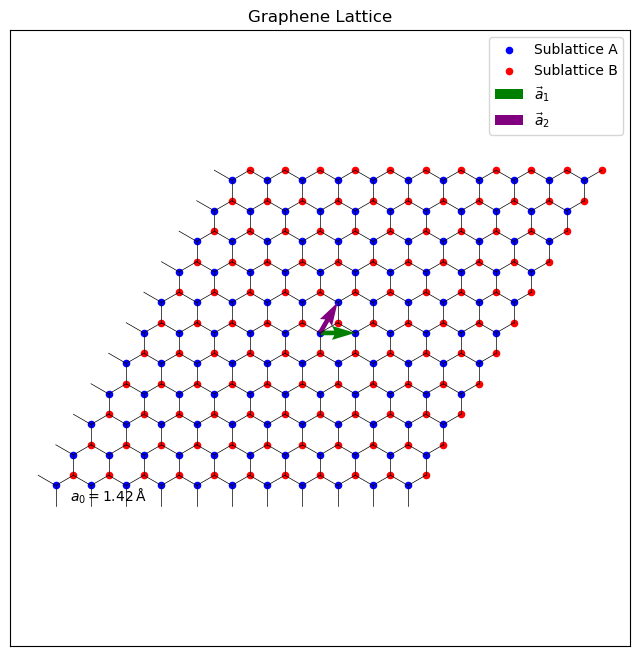

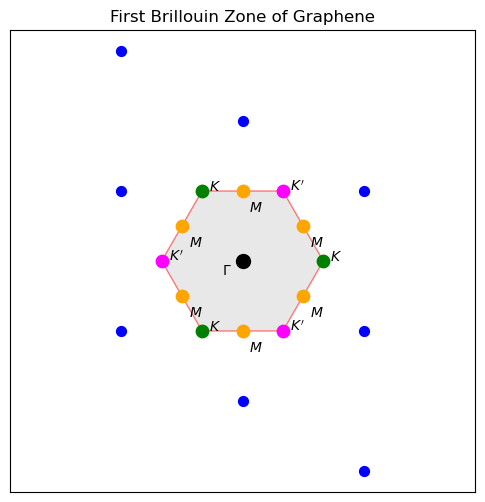

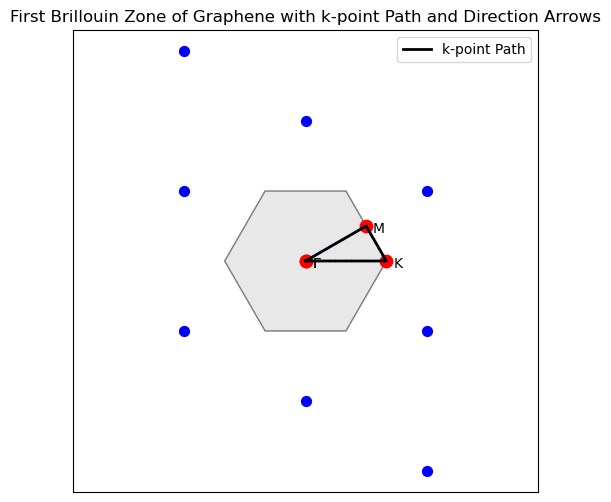

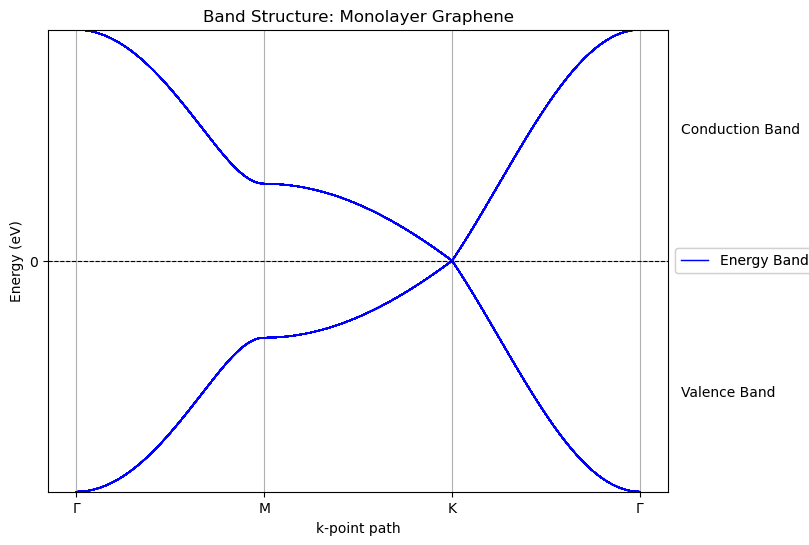

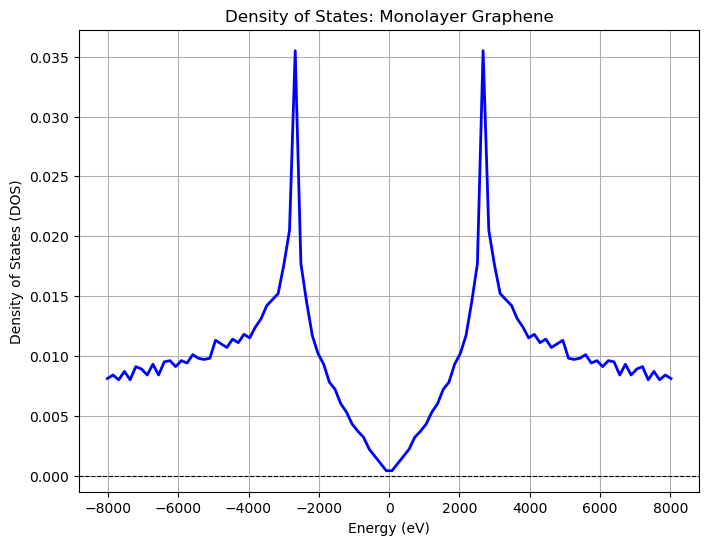

Computed Chern Number: -9.280328107299686e-17


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import rcParams
from scipy.spatial import Voronoi, ConvexHull

# Disable LaTeX rendering to avoid errors
rcParams['text.usetex'] = False

"""Functions"""


def get_reciprocal_lattice_vectors(a):
    """
    Calculates the reciprocal lattice vectors for a 2D lattice.
    """
    # Construct the matrix A from direct lattice vectors
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)

    # Compute the inverse of A
    A_inv = np.linalg.inv(A)

    # Calculate the reciprocal lattice vectors
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse

    # The reciprocal lattice vectors are the rows of B
    b1 = B[:, 0]
    b2 = B[:, 1]

    # Store them in an array similar to 'a'
    b = np.array([b1, b2])

    return b

def generate_lattice_points(a, n_max, m_max):
    """
    Generates positions of the atoms in sublattices A and B for the graphene lattice.
    """
    lattice_A = []
    lattice_B = []
    a1, a2 = a[0], a[1]
    # Sublattice B is shifted by delta_shift from sublattice A
    delta_shift = (a1 + a2) / 3

    for n in range(-n_max, n_max + 1):
        for m in range(-m_max, m_max + 1):
            # Position vector for lattice point
            R = n * a1 + m * a2
            lattice_A.append(R)
            lattice_B.append(R + delta_shift)

    return np.array(lattice_A), np.array(lattice_B)

def plot_lattice(lattice_A, lattice_B, a, delta, a0):
    """
    Plots the graphene lattice with bonds between nearest neighbors.
    """
    plt.figure(figsize=(8, 8))
    plt.title('Graphene Lattice')

    # Plot sublattice A atoms
    plt.scatter(lattice_A[:, 0], lattice_A[:, 1], color='blue', label='Sublattice A', s=20)
    # Plot sublattice B atoms
    plt.scatter(lattice_B[:, 0], lattice_B[:, 1], color='red', label='Sublattice B', s=20)

    # Plot bonds between nearest neighbors
    for A_pos in lattice_A:
        for d_vec in delta:
            B_pos = A_pos - d_vec  # Corrected to A_pos - delta
            plt.plot([A_pos[0], B_pos[0]], [A_pos[1], B_pos[1]], color='black', linewidth=0.5)

    # Plot the lattice vectors
    origin = [0, 0]
    plt.quiver(*origin, *a[0], color='green', scale=1, scale_units='xy', angles='xy', label='$\\vec{a}_1$')
    plt.quiver(*origin, *a[1], color='purple', scale=1, scale_units='xy', angles='xy', label='$\\vec{a}_2$')

    # Label the side of the hexagon
    A_atom = lattice_A[0]
    B_atom = A_atom - delta[0]
    mid_point = (A_atom + B_atom) / 2
    plt.annotate(f'$a_0 = {a0:.2f}\\, \\mathrm{{\\AA}}$', xy=mid_point, xytext=(10, 0),
                 textcoords='offset points', ha='left', va='center', color='black')

    # Ensure equal aspect ratio
    plt.axis('equal')

    # Remove ticks and tick labels
    plt.xticks([])
    plt.yticks([])

    plt.legend()
    plt.show()


def klines(A, B, numpts):
    """
    Generates a linear path of k-points between two endpoints in k-space.
    """
    return np.array([np.linspace(A[jj], B[jj], numpts) for jj in range(len(A))]).T

def special_kline(npts, p1, p2, p3, p4):
    """
    Generates a special k-point path by concatenating linear paths between significant points.
    """
    kline1 = klines(p1, p2, npts)
    kline2 = klines(p2, p3, npts)
    kline3 = klines(p3, p4, npts)
    kpath = np.concatenate((kline1[:-1], kline2[:-1], kline3))
    klabels = ['Γ', 'M', 'K', 'Γ']
    kcoord = np.array([0, npts - 1, 2 * (npts - 1), 3 * (npts - 1)])
    return kpath, kcoord, klabels

def plot_fbz(b):
    """
    Plots the First Brillouin Zone (FBZ) using the reciprocal lattice vectors.
    """
    # Generate reciprocal lattice points
    N = 1  # Include immediate neighbors
    reciprocal_lattice_points = []
    b1, b2 = b[0], b[1]
    for n in range(-N, N + 1):
        for m in range(-N, N + 1):
            K_point = n * b1 + m * b2
            reciprocal_lattice_points.append(K_point)
    reciprocal_lattice_points = np.array(reciprocal_lattice_points)

    # Create Voronoi diagram to find the FBZ
    vor = Voronoi(reciprocal_lattice_points)

    # Identify the region corresponding to the origin (Gamma point)
    center_indices = np.where(np.all(np.isclose(reciprocal_lattice_points, [0, 0], atol=1e-8), axis=1))[0]
    if len(center_indices) == 0:
        raise ValueError("Gamma point not found in reciprocal lattice points.")
    center_index = center_indices[0]

    center_region_index = vor.point_region[center_index]
    center_region = vor.regions[center_region_index]

    # Get the vertices of the FBZ
    vertices = vor.vertices[center_region]

    # Order the vertices counter-clockwise
    hull = ConvexHull(vertices)
    vertices = vertices[hull.vertices]

    # High-symmetry points
    Gamma = np.array([0, 0])

    # Compute the K and K' points explicitly
    K_point = (2 * b[0] + b[1]) / 3
    K_prime_point = -K_point  # Inversion through Gamma point

    # Identify the K and K' points among the vertices
    K_vertices = []
    K_prime_vertices = []
    for vertex in vertices:
        matched = False
        for n in [-1, 0, 1]:
            for m in [-1, 0, 1]:
                shift = n * b[0] + m * b[1]
                if np.allclose(vertex, K_point + shift, atol=1e-8):
                    K_vertices.append(vertex)
                    matched = True
                    break
                elif np.allclose(vertex, K_prime_point + shift, atol=1e-8):
                    K_prime_vertices.append(vertex)
                    matched = True
                    break
            if matched:
                break

    # Compute M points as midpoints of edges between vertices
    M_vertices = []
    num_vertices = len(vertices)
    for i in range(num_vertices):
        start_vertex = vertices[i]
        end_vertex = vertices[(i + 1) % num_vertices]
        midpoint = (start_vertex + end_vertex) / 2
        M_vertices.append(midpoint)

    # Plot the FBZ
    plt.figure(figsize=(6, 6))
    plt.title('First Brillouin Zone of Graphene')

    # Plot the FBZ polygon
    polygon = Polygon(vertices, closed=True, facecolor='lightgray', edgecolor='red', alpha=0.5)
    plt.gca().add_patch(polygon)

    # Plot the reciprocal lattice points
    plt.scatter(reciprocal_lattice_points[:, 0], reciprocal_lattice_points[:, 1], color='blue', s=50)

    # Mark and label the Gamma point
    plt.scatter(Gamma[0], Gamma[1], color='black', s=100)
    plt.annotate('$\\Gamma$', xy=(Gamma[0], Gamma[1]), xytext=(-15, -10), textcoords='offset points')

    # Label K points
    for K in K_vertices:
        plt.scatter(K[0], K[1], color='green', s=80)
        plt.annotate('$K$', xy=(K[0], K[1]), xytext=(5, 0), textcoords='offset points')

    # Label K' points
    for K_prime in K_prime_vertices:
        plt.scatter(K_prime[0], K_prime[1], color='magenta', s=80)
        plt.annotate("$K'$", xy=(K_prime[0], K_prime[1]), xytext=(5, 0), textcoords='offset points')

    # Label M points
    for M in M_vertices:
        plt.scatter(M[0], M[1], color='orange', s=80)
        plt.annotate('$M$', xy=(M[0], M[1]), xytext=(5, -15), textcoords='offset points')

    # Ensure equal aspect ratio
    plt.axis('equal')

    # Remove ticks and tick labels
    plt.xticks([])
    plt.yticks([])

    plt.show()

def plot_fbz_with_kpath(b, k_path_full, high_symmetry_points, klabels):
    """
    Plots the First Brillouin Zone (FBZ) and the k-point path with arrows to indicate direction.
    """
    # Generate reciprocal lattice points
    N = 1
    reciprocal_lattice_points = []
    b1, b2 = b[0], b[1]
    for n in range(-N, N + 1):
        for m in range(-N, N + 1):
            K_point = n * b1 + m * b2
            reciprocal_lattice_points.append(K_point)
    reciprocal_lattice_points = np.array(reciprocal_lattice_points)

    # Create Voronoi diagram to find the FBZ
    vor = Voronoi(reciprocal_lattice_points)
    center_indices = np.where(np.all(np.isclose(reciprocal_lattice_points, [0, 0], atol=1e-8), axis=1))[0]
    center_index = center_indices[0]
    center_region_index = vor.point_region[center_index]
    center_region = vor.regions[center_region_index]
    vertices = vor.vertices[center_region]
    hull = ConvexHull(vertices)
    vertices = vertices[hull.vertices]

    # Plot the FBZ
    plt.figure(figsize=(6, 6))
    plt.title('First Brillouin Zone of Graphene with k-point Path and Direction Arrows')

    # Plot the FBZ polygon
    polygon = Polygon(vertices, closed=True, facecolor='lightgray', edgecolor='black', alpha=0.5)
    plt.gca().add_patch(polygon)

    # Plot reciprocal lattice points
    plt.scatter(reciprocal_lattice_points[:, 0], reciprocal_lattice_points[:, 1], color='blue', s=50)

    # Mark and label high-symmetry points
    for point, label in zip(high_symmetry_points, klabels):
        plt.scatter(point[0], point[1], color='red', s=80)
        plt.annotate(label, xy=(point[0], point[1]), xytext=(5, -5), textcoords='offset points')

    # Plot the k-point path with arrows
    plt.plot(k_path_full[:, 0], k_path_full[:, 1], color='black', linewidth=2, label='k-point Path')

    # Add arrows to indicate direction
    arrow_interval = 20  # Add arrows every 'arrow_interval' points
    for i in range(0, len(k_path_full) - arrow_interval, arrow_interval):
        start = k_path_full[i]
        end = k_path_full[i + arrow_interval]
        arrow_direction = end - start
        plt.arrow(start[0], start[1], arrow_direction[0], arrow_direction[1], head_width=0.03, head_length=0.03, fc='blue', ec='blue')

    # Ensure equal aspect ratio
    plt.axis('equal')

    # Remove ticks and tick labels
    plt.xticks([])
    plt.yticks([])

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

def generate_kpoint_grid(N, b1, b2):
    """
    Generates a grid of k-points for a given N value and reciprocal lattice vectors b1, b2.
    
    Parameters:
    - N: int, the range parameter for the grid (-N to +N).
    - b1, b2: numpy arrays, the reciprocal lattice vectors.
    
    Returns:
    - L: numpy array of shape (siteN, 2), grid of k-point shifts in terms of (n1, n2).
    """
    siteN = (2 * N + 1) ** 2  # Total number of k-points in the grid
    L = np.zeros((siteN, 2))   # Grid of k-point shifts
    k = 0                      # Counter
    
    # Loop over the grid, generating shifts n1 and n2
    for i in np.arange(2 * N + 1):
        for j in np.arange(2 * N + 1):
            L[k, 0] = i - N
            L[k, 1] = j - N
            k += 1
    
    return L
    
def fk(kx, ky):
    """
    Computes the fk function based on the momentum and nearest neighbor vectors.
    
    Parameters:
    - kx, ky: float, components of the k-vector.
    - delta: numpy array, the nearest neighbor vectors.
    
    Returns:
    - fk_value: complex, the computed value for f(k).
    """
    fk_value = 0
    for d in delta:
        fk_value += np.exp(1j * (kx * d[0] + ky * d[1]))

    #print("delk")
    #print(fk_value)
    return fk_value

def Hamiltonian(kx, ky, siteN, L, b1, b2, t):
    """
    Constructs the Hamiltonian matrix for a monolayer graphene system.
    
    Parameters:
    - kx, ky: float, the components of the k-vector in the FBZ.
    - siteN: int, the total number of sites in the grid.
    - L: numpy array, the grid of indices (n1, n2) for the grid points.
    - b1, b2: numpy arrays, the reciprocal lattice vectors.
    - fk_values: numpy array, the precomputed fk values for each site.
    - t: float, the hopping parameter.
    
    Returns:
    - H: numpy array, the Hamiltonian matrix.
    """
    H = np.zeros((2 * siteN, 2 * siteN), dtype=complex)  # Monolayer case, 2x2 blocks

    for i in range(siteN):
        n1 = L[i, 0]
        n2 = L[i, 1]
        q1 = np.array([kx, ky]) + n1 * b1 + n2 * b2
        #print(q1)
        fk_value = fk(q1[0],q1[1])
        H[2 * i, 2 * i + 1] = -t * fk_value  # Row 0, Col 1 (hopping)
        H[2 * i + 1, 2 * i] = -t * np.conjugate(fk_value)  # Row 1, Col 0 (conjugate hopping)
        #print("delk in Ham")
        #print(fk_value)
        #print(H[2*i:2*i+2, 2*i:2*i+2])
    #print(H)
    return H


def compute_eigenvalues_on_kpath(k_path, siteN, L, b1, b2, t):
    """
    Computes the eigenvalues of the Hamiltonian at each k-point along the k-path.

    Parameters:
    - k_path: numpy array, array of k-points along the special k-path.
    - siteN: int, total number of sites.
    - L: numpy array, the grid of indices (n1, n2) for the grid points.
    - b1, b2: numpy arrays, the reciprocal lattice vectors.
    - t: float, hopping parameter.

    Returns:
    - eigenvalues_all: numpy array, sorted eigenvalues for each k-point.
    """
    eigenvalues_all = []

    # Loop over each k-point in the k-path
    for k_point in k_path:
        kx, ky = k_point

        # Compute the Hamiltonian at this k-point using the Hamiltonian function
        H = Hamiltonian(kx, ky, siteN, L, b1, b2, t)

        # Compute the eigenvalues of the Hamiltonian
        eigenvalues = np.linalg.eigvalsh(H)  # Use eigvalsh to compute the eigenvalues of a Hermitian matrix

        # Sort the eigenvalues
        eigenvalues_sorted = np.sort(eigenvalues)
        #print(eigenvalues)

        # Append the sorted eigenvalues for this k-point
        eigenvalues_all.append(eigenvalues_sorted)

    return np.array(eigenvalues_all)

def plot_bandstructure(k_path_full, siteN, L, b1, b2, t, kcoord, klabels,zoomed):
    """
    Computes and plots the band structure for the given k-path, showing both the full plot and a zoomed-in view near the K-point.

    Parameters:
    - k_path_full: numpy array, array of k-points along the k-path.
    - siteN: int, the total number of sites in the grid.
    - L: numpy array, the grid of indices (n1, n2) for the grid points.
    - b1, b2: numpy arrays, the reciprocal lattice vectors.
    - t: float, the hopping parameter.
    - kcoord: list, indices of high-symmetry points along the k-path.
    - klabels: list, labels for high-symmetry points.
    """
    num_kpoints = len(k_path_full)
    num_bands = 2 * siteN  # 2x2 blocks for monolayer graphene
    E = np.zeros((num_kpoints, num_bands))  # Array to store eigenvalues

    # Loop over each k-point in the k-path
    for idx in range(num_kpoints):
        kx, ky = k_path_full[idx]
        
        # Compute the Hamiltonian for this k-point
        H = Hamiltonian(kx, ky, siteN, L, b1, b2, t)
        
        # Compute the eigenvalues of the Hamiltonian
        eigvals = np.linalg.eigvalsh(H)
        
        # Sort and store the eigenvalues
        E[idx, :] = np.sort(np.real(eigvals))
    
    # Plot 1: Full Band Structure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the band structure for all k-points
    for band in range(num_bands):
        ax.plot(np.arange(num_kpoints), E[:, band], color='blue', lw=1)
    
    # Add Fermi level marker
    ax.axhline(0, color='black', linestyle='--', lw=0.8)

    # X-axis ticks only at high symmetry points
    ax.set_xticks(kcoord)
    ax.set_xticklabels(klabels)

    # Remove y-axis ticks except for Fermi level (0 eV)
    ax.set_yticks([0])
    
    # Add title and labels
    ax.set_xlabel("k-point path")
    ax.set_ylabel("Energy (eV)")
    ax.set_title("Band Structure: Monolayer Graphene")
    
    # Full y-limits for the band structure
    ax.set_ylim([-3 * t, 3 * t])
    
    # Add legends for Energy Bands, Conduction, and Valence Bands
    legend1 = ax.legend(['Energy Bands'], loc='center left', bbox_to_anchor=(1, 0.5))
    ax.add_artist(legend1)
    ax.text(1.02, 0.8, 'Conduction Band', transform=ax.transAxes, verticalalignment='top')
    ax.text(1.02, 0.2, 'Valence Band', transform=ax.transAxes, verticalalignment='bottom')
    
    # Show the full band structure plot
    plt.grid(True)
    plt.show()

    if zoomed:
        # Plot 2: Zoomed Band Structure centered at K-point
        plt.figure(figsize=(8, 6))
        
        # Plot the band structure for all k-points
        for band in range(num_bands):
            plt.plot(np.arange(num_kpoints), E[:, band], color='blue', lw=1)
        
        # Add Fermi level marker
        plt.axhline(0, color='black', linestyle='--', lw=0.8)
    
        # X-axis ticks only at high symmetry points
        plt.xticks(kcoord, klabels)
    
        # Remove y-axis ticks except for Fermi level (0 eV)
        plt.yticks([0])
        
        # Add title and labels
        plt.xlabel("k-point path")
        plt.ylabel("Energy (eV)")
        plt.title("Band Structure: Monolayer Graphene (Zoomed at K-point)")
    
        # Zoom-in centered around the K-point
        midpoint_K = (kcoord[2] + kcoord[1]) / 2  # Approximate midpoint between M and K
        plt.xlim(midpoint_K - 0.2 * num_kpoints, midpoint_K + 0.2 * num_kpoints)  # Zoom-in range centered on K
        plt.ylim(-t / 2, t / 2)  # Adjust y-limits for zoomed energy range
        
        # Add legend on the right
        plt.legend(['Energy Bands'], loc='center left', bbox_to_anchor=(1, 0.5))
        
        # Show zoomed band structure
        plt.grid(True)
        plt.show()

def generate_k_grid(num_kpoints, b1, b2):
    kx_vals = np.linspace(-0.5, 0.5, num_kpoints)
    ky_vals = np.linspace(-0.5, 0.5, num_kpoints)
    kx_grid, ky_grid = np.meshgrid(kx_vals, ky_vals)
    kx_grid = kx_grid.flatten()
    ky_grid = ky_grid.flatten()
    kx = kx_grid * b1[0] + ky_grid * b2[0]
    ky = kx_grid * b1[1] + ky_grid * b2[1]
    return kx, ky

def compute_eigenvalues_dos(kx_grid, ky_grid, siteN, L, b1, b2, t):
    num_kpoints = len(kx_grid)
    num_bands = 2 * siteN  
    eigenvalues = np.zeros((num_kpoints, num_bands))
    for idx in range(num_kpoints):
        kx, ky = kx_grid[idx], ky_grid[idx]
        H = Hamiltonian(kx, ky, siteN, L, b1, b2, t)
        eigvals = np.linalg.eigvalsh(H)
        eigenvalues[idx, :] = np.sort(np.real(eigvals))
    return eigenvalues.flatten()

def compute_DOS(eigenvalues, num_bins=100, energy_range=None):
    if energy_range is None:
        energy_min = np.min(eigenvalues)
        energy_max = np.max(eigenvalues)
    else:
        energy_min, energy_max = energy_range
    dos, energy_bins = np.histogram(eigenvalues, bins=num_bins, range=(energy_min, energy_max), density=True)
    dos = dos / np.sum(dos)
    plt.figure(figsize=(8, 6))
    plt.plot(0.5 * (energy_bins[1:] + energy_bins[:-1]), dos, color='blue', lw=2)
    plt.axhline(0, color='black', linestyle='--', lw=0.8)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Density of States (DOS)")
    plt.title("Density of States: Monolayer Graphene")
    plt.grid(True)
    plt.show()
    return dos

def compute_berry_phase(u1, u2, u3, u4):
    """
    Compute the Berry phase for a plaquette with wavefunctions at four corners.
    u1, u2, u3, u4 are the eigenstates at the four corners of the plaquette.
    """
    # Compute the overlap of the wavefunctions around the plaquette
    product = np.vdot(u1, u2) * np.vdot(u2, u3) * np.vdot(u3, u4) * np.vdot(u4, u1)
    
    # Return the phase of the product
    return np.angle(product)

def compute_chern_number(N, b1, b2, t):
    """
    Compute the Chern number by summing the Berry phase over all plaquettes in the Brillouin zone.
    
    N: int, number of discretized points in the FBZ.
    b1, b2: reciprocal lattice vectors.
    t: hopping parameter.
    """
    total_phase = 0
    
    # Discretize the FBZ into an N x N grid of k-points
    kx_vals = np.linspace(-np.pi, np.pi, N)
    ky_vals = np.linspace(-np.pi, np.pi, N)
    
    # Define lattice shift grid
    L = generate_kpoint_grid(N, b1, b2)
    
    # Loop over plaquettes
    for i in range(N-1):
        for j in range(N-1):
            # Define the four corners of the plaquette in momentum space
            k1 = [kx_vals[i], ky_vals[j]]
            k2 = [kx_vals[i+1], ky_vals[j]]
            k3 = [kx_vals[i+1], ky_vals[j+1]]
            k4 = [kx_vals[i], ky_vals[j+1]]
            
            # Diagonalize the Hamiltonian at each k-point to get the eigenstates
            H1 = Hamiltonian(k1[0], k1[1], N, L, b1, b2, t)
            H2 = Hamiltonian(k2[0], k2[1], N, L, b1, b2, t)
            H3 = Hamiltonian(k3[0], k3[1], N, L, b1, b2, t)
            H4 = Hamiltonian(k4[0], k4[1], N, L, b1, b2, t)
            
            # Get the lowest eigenstate for each point (assuming the Chern number for the lowest band)
            u1 = np.linalg.eigh(H1)[1][:, 0]
            u2 = np.linalg.eigh(H2)[1][:, 0]
            u3 = np.linalg.eigh(H3)[1][:, 0]
            u4 = np.linalg.eigh(H4)[1][:, 0]
            
            # Compute the Berry phase for this plaquette
            phase = compute_berry_phase(u1, u2, u3, u4)
            
            # Accumulate the total phase
            total_phase += phase
    
    # Compute the Chern number as the sum of Berry phases divided by 2*pi
    Chern_number = total_phase / (2 * np.pi)
    
    return Chern_number
  

def main():
    # **Relevant Parameters**
    # Hopping parameter (meV)
    t = 2700
    
    # Carbon-carbon bond distance (Ångströms)
    a0 = 1.42
    
    # Lattice constant (Ångströms)
    d = a0 * np.sqrt(3)
    
    # Reciprocal lattice constant (1/Å)
    kD = 4 * np.pi / (3 * a0 * np.sqrt(3))
    
    # **Lattice Vectors**
    a = np.array([
        [d, 0],
        d * np.array([0.5, np.sqrt(3)/2])
    ])
    
    # **Nearest Neighbor Vectors (Corrected)**
    delta1 = -(1/3) * a[0] + (2/3) * a[1]
    delta2 = (-1/3) * a[0] - (1/3) * a[1]
    delta3 = (2/3) * a[0] - (1/3) * a[1]
    delta = np.array([delta1, delta2, delta3])
    
    
    
    
    
    # Calculate the reciprocal lattice vectors
    b = get_reciprocal_lattice_vectors(a)
    b1, b2 = b[0], b[1]
    
    # **Generate Lattice Points**
    n_max = 5  # Adjust for desired lattice size
    m_max = 5
    lattice_A, lattice_B = generate_lattice_points(a, n_max, m_max)
    
    # **Plot the Lattice and FBZ**
    plot_lattice(lattice_A, lattice_B, a, delta, a0)
    plot_fbz(b)
    
    
    # **Plot the FBZ and the k-point Path**
    Gamma = np.array([0, 0])
    K = (2/3) * b1 + (1/3) * b2
    M = (b1 + b2) / 2
    
    npts = 100
    k_path_full, kcoord, klabels = special_kline(npts, Gamma, M, K, Gamma)
    
    # Plot the FBZ and the k-point path
    plot_fbz_with_kpath(b, k_path_full, [Gamma, M, K, Gamma], klabels)
    
    N = 4
    siteN = (2 * N + 1) ** 2
    L = generate_kpoint_grid(N, b1, b2)  # Generate the grid
    
    # Use this function to plot the band structure
    plot_bandstructure(k_path_full, siteN, L, b1, b2, t, kcoord, klabels, zoomed = False)


    # DOS computation
    num_kpoints = 100
    kx_grid, ky_grid = generate_k_grid(num_kpoints, b1, b2)
    eigenvalues = compute_eigenvalues_dos(kx_grid, ky_grid, siteN, L, b1, b2, t)
    compute_DOS(eigenvalues, num_bins=100)


    # Discretize the FBZ
    N = 30  # Number of k-points along each direction
    
    # Compute the Chern number
    Chern_number = compute_chern_number(N, b1, b2, t)
    
    # Output the result
    print(f"Computed Chern Number: {Chern_number}")

main()
